In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
#YOLO Model Architecture to load the downloaded weigths

keras.backend.set_image_dim_ordering('th')
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [3]:
#The loading weights code is obtained from https://github.com/xslittlegrass/CarND-Vehicle-Detection/blob/master/utils/utils.py

def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

In [4]:
#Loading the weights of the model
load_weights(model,'yolo-tiny.weights')

In [5]:
# Preprocessing
def preprocessing(image):
    
    #The image is cropped to reduce and size and not loose value data during resize
    cropped = image[300:650,500:,:]
    #The image is resized to make to be of the input image size i.e, 448*448
    resized=cv2.resize(cropped, (448,448))
    #The image is then normalized
    normalized = resized/255.0 - 0.5
    #The image is transposed to since our model needs input of size (3, 448, 448) and not (448, 448,3)
    transposed = np.transpose(normalized, (2,0,1))
    #We are changing the input to (1,3,448,448) since we send single images to neural network
    batch = np.expand_dims(transposed, axis=0)
    
    return batch

In [6]:
#We are reading a simple image and predicting the output
test_image = mpimg.imread('test_images/test1.jpg')
predict_image = preprocessing(test_image)
predict_output = model.predict(predict_image)

In [7]:
#The code is inspired from https://github.com/xslittlegrass/CarND-Vehicle-Detection/ to which i made many changes and explained what each line does 

def yolo_net_out_to_car_boxes(net_out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    
    #The values C,B and S are predefined values for this model
    
    class_num = 6 #In this model number 6 is the label equivalent of car
    boxes = []
    
    #we are initalizing the values based on the model label
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell
    
    #we are getting the probability, confidance score and coordinates from the predict_output
    probs = net_out[0 : prob_size] #since there are 49 grids with 20 classes, there will be total of 980 values
    confs = net_out[prob_size : (prob_size + conf_size)] #since there are 49 grids with 2 conf score, total of 98 values
    cords = net_out[(prob_size + conf_size) : ] # Since there are 4 coordinates for 98 values, total of 392 values
    
    #So from the above the 1470 values of the labels are successfully split between the probability, confidance score and coordinates
    
    #Now we are reshaping the array so that we can loop every boxes
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    #Now we are looping into every grid and box to find their  x,y,w,h and probability values
    for grid in range(SS):
        for b in range(B):
            #The below  contains x,y,w,h and probability values of a single bounding box
            c =  confs[grid, b]
            x = (cords[grid, b, 0] + grid %  S) / S
            y = (cords[grid, b, 1] + grid // S) / S
            w =  cords[grid, b, 2] ** sqrt 
            h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * c
            
            if p[class_num] >= threshold:
                prob = p[class_num] #Since the prob is greater than threshold
                boxes.append([x,y,w,h,prob])
    
    #Soring the boxes array such the highest probabilty comes first
    boxes = sorted(boxes,key=lambda x:x[4],reverse=True)
    
    # Seraching for the boxes that overlap and turn their probability to zero
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi[4] == 0: 
            continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            w1=min(((boxi[0]+boxi[2])/2),((boxj[0]+boxj[2])/2))-max(((boxi[0]-boxi[2])/2),((boxj[0]-boxj[2])/2))
            h1=min(((boxi[1]+boxi[3])/2),((boxj[1]+boxj[3])/2))-max(((boxi[1]-boxi[3])/2),((boxj[1]-boxj[3])/2))
            if w1 < 0 or h1 < 0: 
                intersection=0
            intersection = w1 * h1
            union=(boxi[2]*boxi[3]) + (boxj[2]*boxj[3]) - intersection          
            
            if intersection / union >= .4:
                boxj[4] = 0.

    boxes = [b for b in boxes if b[4]> 0.]
    
    return boxes

In [8]:
result=yolo_net_out_to_car_boxes(predict_output[0], threshold = 0.17, sqrt=1.8,C=20, B=2, S=7)

In [9]:
#Fucntional block to draw the boxes

def draw_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b[0] - b[2]/2.) * w)
        right = int ((b[0] + b[2]/2.) * w)
        top   = int ((b[1] - b[3]/2.) * h)
        bot   = int ((b[1] + b[3]/2.) * h)
        
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (0,255,0), thick)

    return imgcv

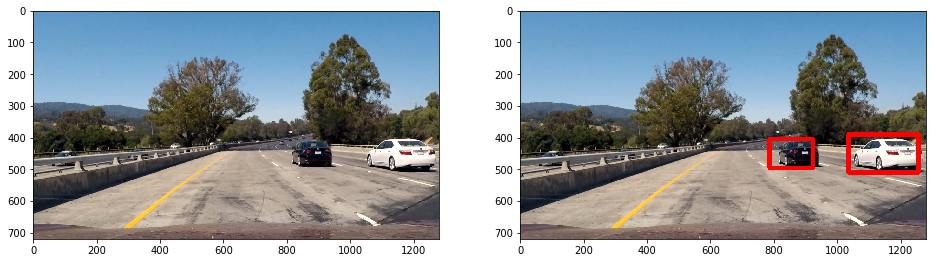

In [10]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(test_image)
ax2.imshow(draw_box(result,test_image,[[500,1280],[300,650]]))

In [11]:
def image_pipeline(image):
    image_predict = preprocessing(image)
    output_predict = model.predict(image_predict)
    box_result=yolo_net_out_to_car_boxes(output_predict[0], threshold = 0.17, sqrt=1.8,C=20, B=2, S=7)
    final_image=draw_box(box_result,image,[[500,1280],[300,650]])
    return final_image

In [12]:
import os
images=os.listdir("test_images/")
for i in images:
    image = mpimg.imread('test_images/'+str(i))
    result = image_pipeline(image)
    mpimg.imsave("output_images_yolo/"+str(i), result)

In [13]:
#Exeuting the video and saving it to the output folder
yellow_output = 'project_video_output_yolo.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_output_yolo.mp4
[MoviePy] Writing video project_video_output_yolo.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [50:51<00:02,  2.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_yolo.mp4 

Wall time: 50min 54s


In [18]:
from advanced_lane_finding import undistort_image,color_gradient_threshold,warper,lane_line,draw_line,draw_curvature,camera_calibration

In [21]:
mtx,dist=camera_calibration()

def combined_pipeline(image):
    
    img_size=image.shape
    src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 6) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32( [[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])
    
    undist_image=undistort_image(image,mtx,dist)
    binary_image=color_gradient_threshold(undist_image)
    warped_image,MinV=warper(binary_image,src,dst)
    left_fit,right_fit=lane_line(warped_image)
    result=draw_line(undist_image,warped_image,left_fit,right_fit,MinV)
    final=draw_curvature(result,left_fit,right_fit)
    
    image_predict = preprocessing(undist_image)
    output_predict = model.predict(image_predict)
    box_result=yolo_net_out_to_car_boxes(output_predict[0], threshold = 0.17, sqrt=1.8,C=20, B=2, S=7)    
    final_image=draw_box(box_result,final,[[500,1280],[300,650]])
    
    return final_image
    
    
    

In [24]:
#Exeuting the video and saving it to the output folder
yellow_output = 'project_video_combined_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(combined_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_combined_output.mp4
[MoviePy] Writing video project_video_combined_output.mp4



  5%|████▏                                                                         | 67/1261 [04:51<1:07:54,  3.41s/it]


 11%|████████▍                                                                      | 135/1261 [07:43<46:39,  2.49s/it]


 16%|████████████▋                                                                  | 203/1261 [10:28<43:04,  2.44s/it]


 21%|████████████████▉                                                              | 271/1261 [13:37<42:19,  2.57s/it]


 27%|█████████████████████▏                                                         | 339/1261 [16:29<40:22,  2.63s/it]


 32%|█████████████████████████▍                                                     | 407/1261 [19:36<36:35,  2.57s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [22:32<32:42,  2.50s/it]


 43%|██████████████████████████████████                                             | 543/1261 [25:23<28:32,  2.38s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [28:31<37:06,  3.43s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [31:32<19:54,  2.05s/it]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [34:12<18:57,  2.21s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [36:45<15:48,  2.13s/it]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [39:54<13:38,  2.16s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [42:21<12:12,  2.36s/it]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [44:48<08:39,  2.15s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [47:21<06:22,  2.20s/it]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [49:52<03:40,  2.08s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [52:29<01:22,  2.18s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [53:51<00:02,  2.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_combined_output.mp4 

Wall time: 53min 53s
